# Stabilität von kreisförmigen Bögen

Hier wollen wir die kritische Belastung sowie das Nachbeulverhalten von kreisförmigen Bögen berechnen. 

<img src="circularArchPressure.png" alt="Arch" style="display:block; margin:auto;">
<div style="text-align:center; font-size:90%;">Abb. 1: Kreisförmiger Bogen unter radialer Linienlast</div>

Wird dieser, wie in Abb.1, mit einer konstanten, radialen Linienlast belastet existiert eine analytische Lösung. Der Bogen knickt bei
\begin{equation}
    p_k = \frac{EI_y}{R^3}\left(\frac{\pi^2}{\alpha^2} - 1\right)
\end{equation}
aus. Ein derartiger Lastfall war im Schiffsbau von großer Bedeutung.

In [1]:
# libraries
from GeoNonlinear_FEM_lib import GNLexamples, FEMsolve, ANSYS, B2D_LR, B2D_SR_ML, B2D_SR
import numpy as np
import matplotlib.pyplot as plt
import copy

# critical load
def p_k(E,I,R,alpha):
    return (E*I/R**3)*(np.pi**2/alpha**2 - 1)

Neben der kritischen Belastung soll auch das Nachbeulverhalten vom Kreisbogen untersucht werden.Dafür ist aber eine Finite-Elemente Berechnung erforderlich, die nachfolgend schrittweise aufgebaut wird.

### Finite-Elemente Berechnung

#### Systemparameter
Nachfolgend werden die Systemparameter definiert. Es können natürlich auch andere Werte gewählt werden.

In [2]:
R = 40.0                    # Radius des Bogens in m
alpha = 20/180*np.pi        # Halber Öffnungswinkel in rad
E = 2.1E11                  # Elastizitätsmodul in Pa
nu = 0.3                    # Querkontraktionszahl
b = 0.1                     # Breite des Querschnitts in m
h = 0.2                     # Höhe des Querschnitts in m
I = b * h**3 / 12           # Flächenträgheitsmoment in m^4

#### Diskretisierung
In diesem Abschnitt wird die Diskretisierung des Kreisbogens erzeugt. Die Referenzbelastung wird (fast) beliebig gewählt. Die Anzahl der Elemente wird auch zunächst willkürlich definiert. Abschließend wird die Diskretisierung geplottet.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


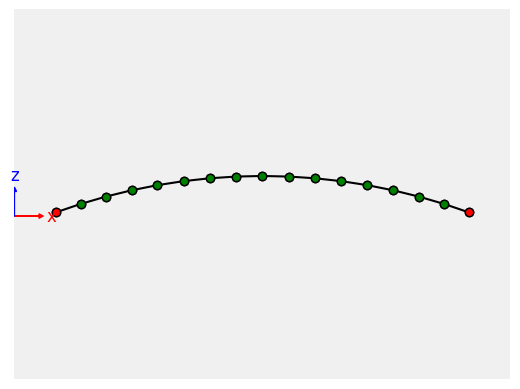

In [3]:
# analytische kritische Last
pk = p_k(E,I,R,alpha)
# (beliebige) Referenzlast
p0 = 0.1*pk
# Anzahl der Elemente
numEl = 16
# Diskretisierung
mesh = GNLexamples.shallowArch(loadCase = "pressure", n = numEl, R = R, alpha = alpha, F = p0, b = b, h = h, elType = B2D_SR_ML)
mesh.plotMesh()

### Lastgesteuerte Berechnung der Strukturantwort 

Es wird die Belastung inkrementweise aufgebracht und der Gleichgewichtszustand für jede Laststufe ermittelt. Über *numInc* wird die Anzahl der Lastinkremente definiert. Da die Belastung somit schrittweise gesteigert wird, spricht man von einer lastgesteuerten Analyse. Im Last--Verschiebungsdiagramm wird der Lastfaktor $\lambda$ über eine charakteristische Verschiebung  $u_{mon}$ aufgetragen. Beim vorliegenden Kreisbogen ist dies die Vertikalverschiebung des Scheitelpunktes. Ebenfalls wird die Verformung des Kreisbogens skaliert geplottet. 

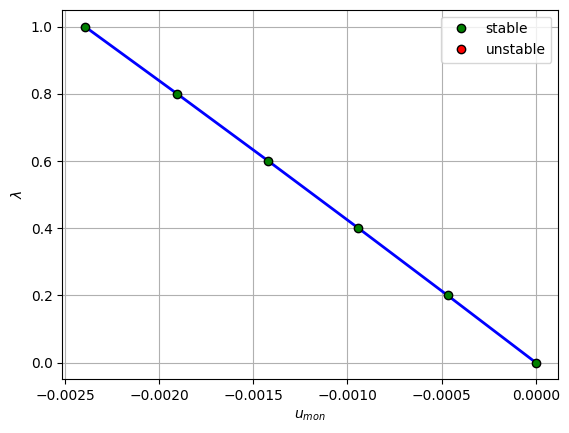

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


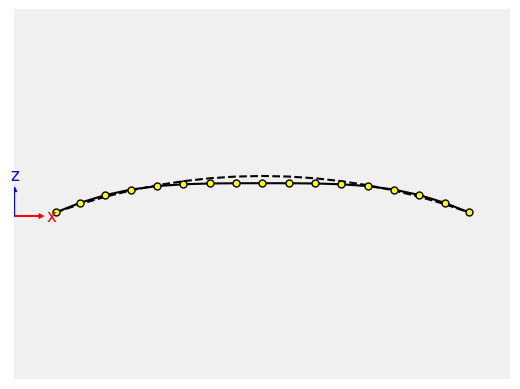

(<matplotlib.lines.Line2D at 0x1f89d43a590>,)

In [4]:
# Berechung der nichtlinearen Strukturantwort
sol = FEMsolve.LoadCon(mesh, numInc = 5)
# plot der Last-Verformungskurve (Vertikalverschiebung des Scheitels)
sol.plotMonitor()
# plotten der Verschiebung (Skalierung 200)
mesh.plotDisplacement(sol.u, scale = 200)

Die Verschiebungen sind noch sehr klein und aus der Last--Verschiebungskurve lässt sich bis zur gewählten Referenzbelastung ein lineares Verhalten erkennen.

### Lineare Beulanalyse

Von dem vorhin ermittelten Gleichgewichtszustand wird eine lineare Beulanalyse durch Lösen des verallgemeinerten Eigenwertproblems
$$
\left( \mathbf{K}_{r} + \Delta \lambda_i \, \mathbf{K}_{g} \right) \boldsymbol{\varphi}_i = \mathbf{0}
$$
durchgeführt. Die Beulmoden $\boldsymbol{\varphi}_i$, wie auch die dazugehörigen kritischen Lasten 
$$
\lambda_k = \lambda_r + \Delta\lambda_i = 1 +  \Delta\lambda_i \quad \rightarrow \quad p_k = \lambda_k p_0
$$
werden geplottet und angegeben. Mit *numModes* wird die Anzahl der zu bestimmenden Beulmoden festgelegt.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


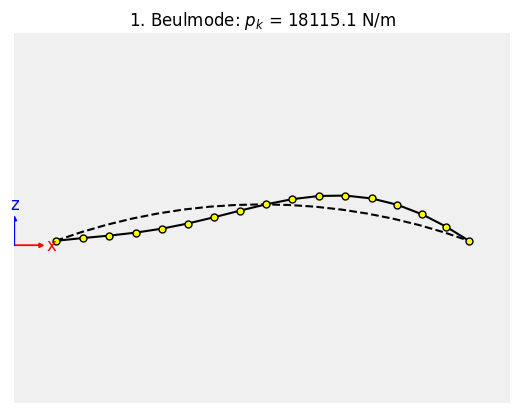

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


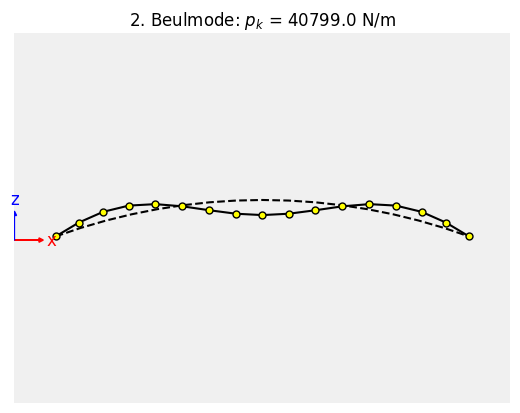

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


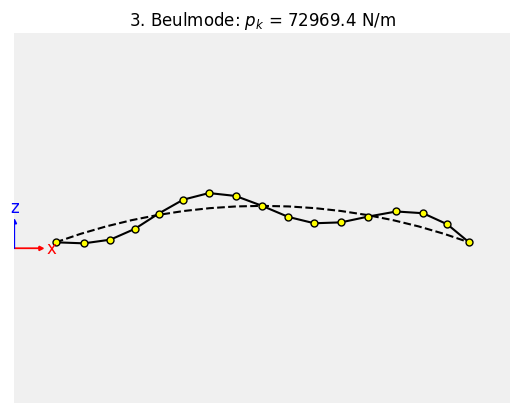

In [5]:
# Anzahl der Beulmoden
numModes = 3

# Lineare Beulanalyse
buckling = FEMsolve.linBuckling(mesh, sol.u, numModes = numModes)

# plotten des der Beulmoden
for i in range(numModes):
    mesh.plotDisplacement(
        buckling.buckModes[:, i],
        title=f"{i+1}. Beulmode: $p_k$ = {p0 *  buckling.LambdaCrit[i]:5.1f} N/m"
    )

Wie können nun diese Ergebnisse interpretiert werden? Als Erstes erkennt man, dass die kritischen Lasten sehr gut separiert sind, d.h. der Unterschied zwischen den einzelnen kritischen Lasten ist groß. Bei stabförmigen Tragwerken ist dies häufig der Fall. Bei Schalenstrukturen liegen kritische Lasten meist deutlich enger zusammen. 

### Konvergenzstudie

Nachfolgend wird eine Konvergenzstudie für die kritisch Belastung durchgeführt, durch Erhöhung der Elementzahl. 

In [6]:
# Anzahl der Elemente für Konvergenzstudie
nEl = np.array([2, 4, 6, 8, 10, 12, 14, 16], dtype=int)

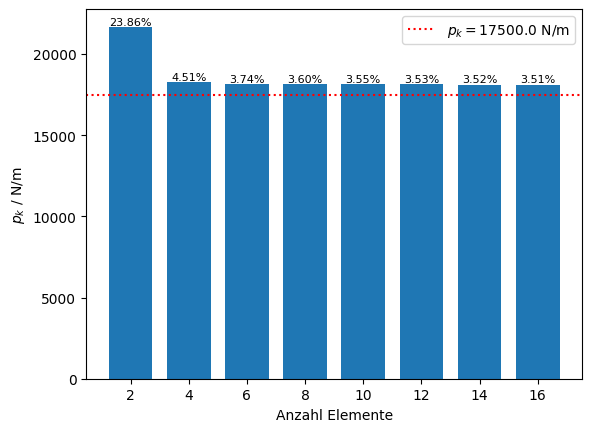

In [7]:
# Konvergenzstudie
# Referenzbelastung
F0 = 1E-1*pk

lambdaCrit = []

for n in nEl:
    # create mesh
    mesh_C = GNLexamples.shallowArch(loadCase="pressure", n=n, R=R, alpha=alpha, F=F0, b=b, h=h, elType=B2D_SR_ML)
    # solve
    sol_C = FEMsolve.LoadCon(mesh_C, numInc=2)
    # linearized buckling analysis
    buckling_C = FEMsolve.linBuckling(mesh_C, sol_C.u, numModes=1)
    # store critical load factor
    lambdaCrit.append(buckling_C.LambdaCrit[0])

# plot results
results = np.array([nEl, F0 * np.array(lambdaCrit)]).T
rel_error = (results[:,1] - pk) / pk

bars = plt.bar(results[:,0], results[:,1], width=1.5)
plt.axhline(pk, color='r', linestyle=':', label=f"$p_k = {pk:5.1f}$ N/m")
plt.xlabel('Anzahl Elemente')
plt.ylabel('$p_k$ / N/m')

for bar, err in zip(bars, rel_error):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{err:.2%}', ha='center', va='bottom', fontsize=8)

plt.legend()
plt.show()

## Nachbeulverhalten

*******************
 ITERATION FAILED!
*******************


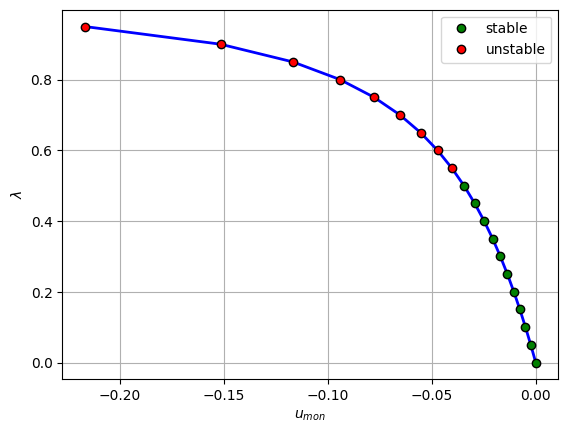

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


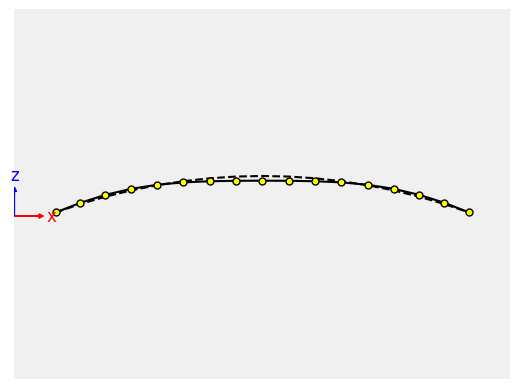

(<matplotlib.lines.Line2D at 0x1f89d49a2f0>,)

In [8]:
F0 = 2*pk
mesh_postB = GNLexamples.shallowArch(loadCase="pressure", n = 16, R=R, alpha=alpha, F=F0, b=b, h=h, elType=B2D_SR_ML)
sol_postB = FEMsolve.LoadCon(mesh_postB, numInc=20)
sol_postB.plotMonitor()
mesh_postB.plotDisplacement(sol_postB.u)

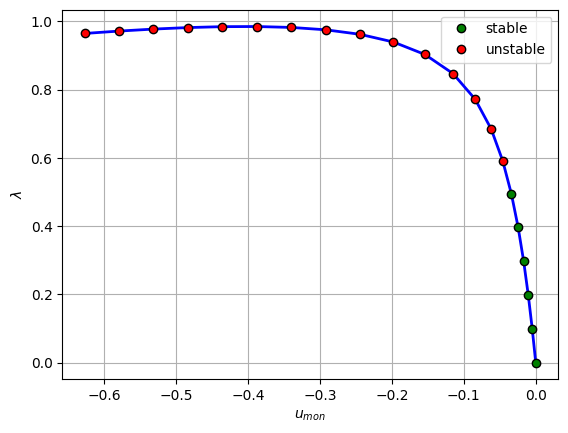

In [16]:
sol_postB_arcL = FEMsolve.arcL(mesh_postB, numInc = 20, Lambda0 = 1)
sol_postB_arcL.plotMonitor()

#### Imperfektionen

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


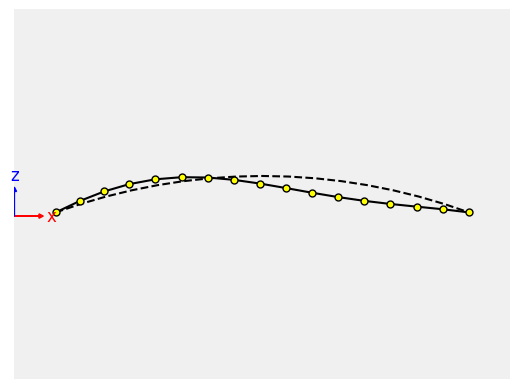

(<matplotlib.lines.Line2D at 0x1f89daf18a0>,)

In [28]:
mesh_imp = copy.deepcopy(mesh_postB)

mesh_imp.imperfection(buckling.buckModes[:,0], scale = 0.001)

sol_postB_imp = FEMsolve.arcL(mesh_imp, numInc = 20, Lambda0 = 1.5)

#sol_postB_imp.plotMonitor()

mesh_imp.plotDisplacement(sol_postB_imp.u)

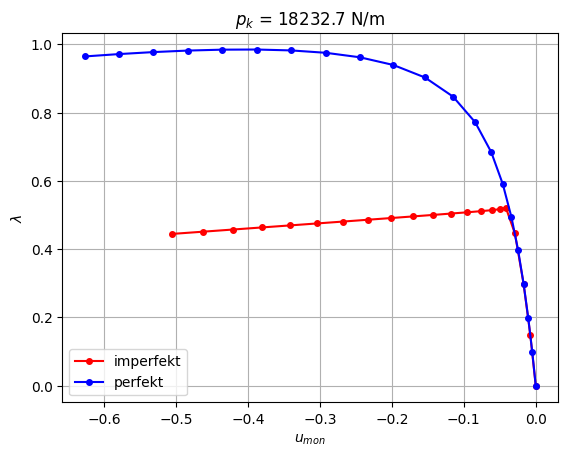

In [30]:
plt.plot(sol_postB_imp.monVal[:,1], sol_postB_imp.monVal[:,0], 'r-o', label='imperfekt', markersize=4)
plt.plot(sol_postB_arcL.monVal[:,1], sol_postB_arcL.monVal[:,0],'b-o', label='perfekt', markersize=4)
plt.xlabel('$u_{mon}$')
plt.ylabel('$\lambda$')
plt.grid()
plt.legend()
plt.title(f"$p_k$ = {F0*np.max(sol_postB_imp.monVal[:,0]):5.1f} N/m")
plt.show()
